Exploratory Data Analysis 
(EDA), visualizations, feature 
selection, and training 
Random Forest, 
Exploratory Analysis, 
Feature Importance, and 
Random Forest results 

In [38]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
import pandas as pd

df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()


customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

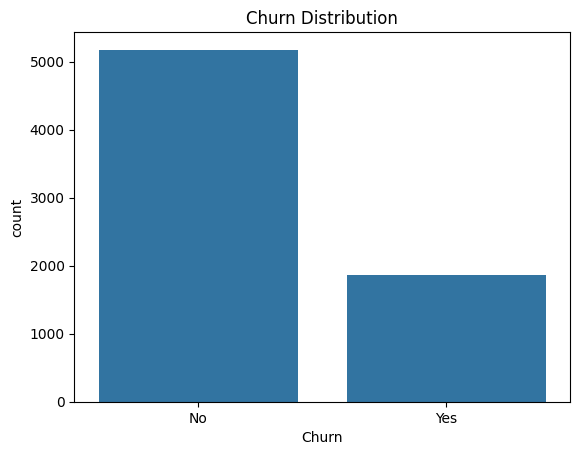

In [39]:
# Churn Distribution
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

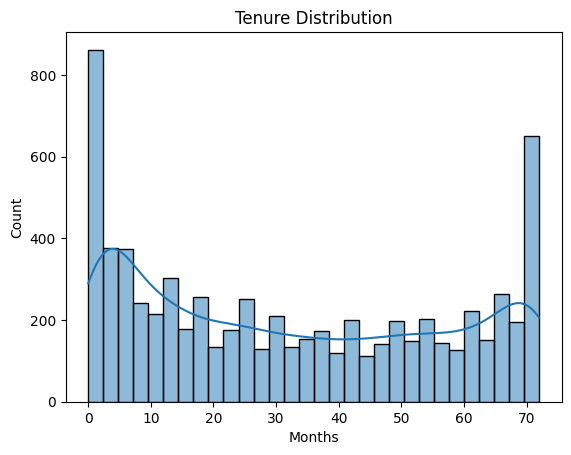

In [40]:
# 3. Distribution of Tenure
sns.histplot(df['tenure'], bins=30, kde=True)
plt.title("Tenure Distribution")
plt.xlabel("Months")
plt.show()


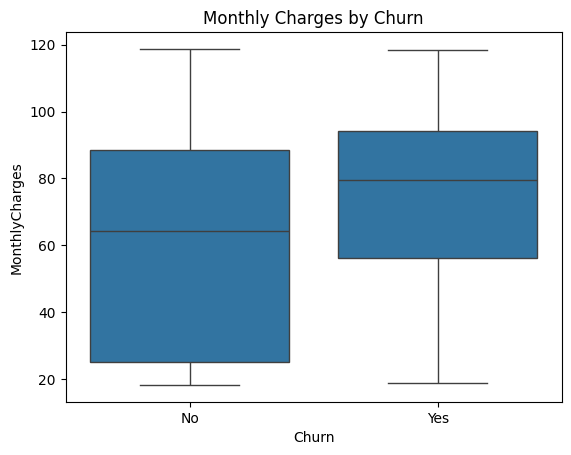

In [41]:
# Monthly Charges vs Churn
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title("Monthly Charges by Churn")
plt.show()



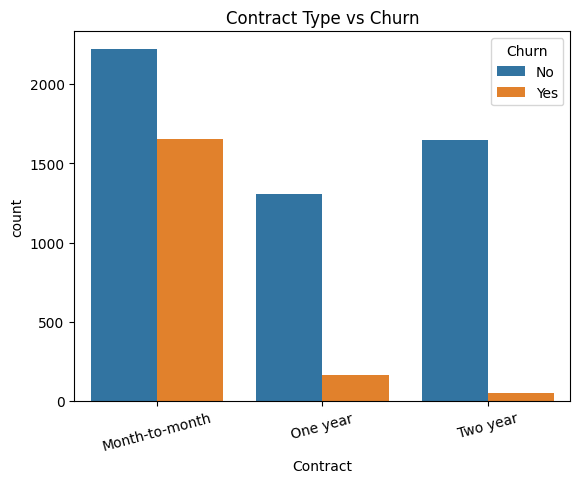

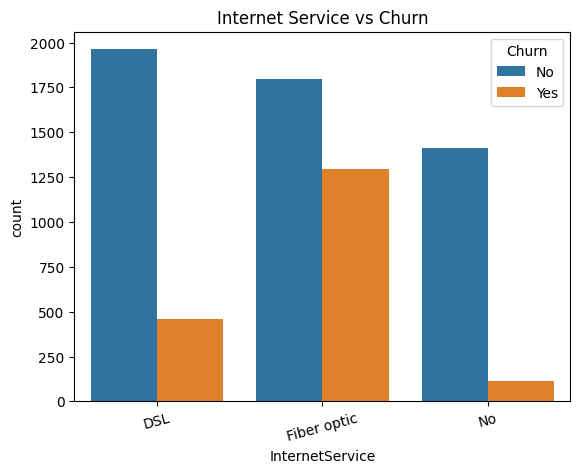

In [42]:
#Contract Type vs Churn
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title("Contract Type vs Churn")
plt.xticks(rotation=15)
plt.show()

# Internet Service Type vs Churn
sns.countplot(x='InternetService', hue='Churn', data=df)
plt.title("Internet Service vs Churn")
plt.xticks(rotation=15)
plt.show()


The churn distribution shows that approximately 26.6% customers classified as churned. The tenure distribution is right-skewed, indicating that a large portion of customers leave within the first year; however, those who remain past this early period are more likely to stay long-term. When comparing monthly charges, churned customers tend to have higher bills - pricing may be a contributing factor to churn. 

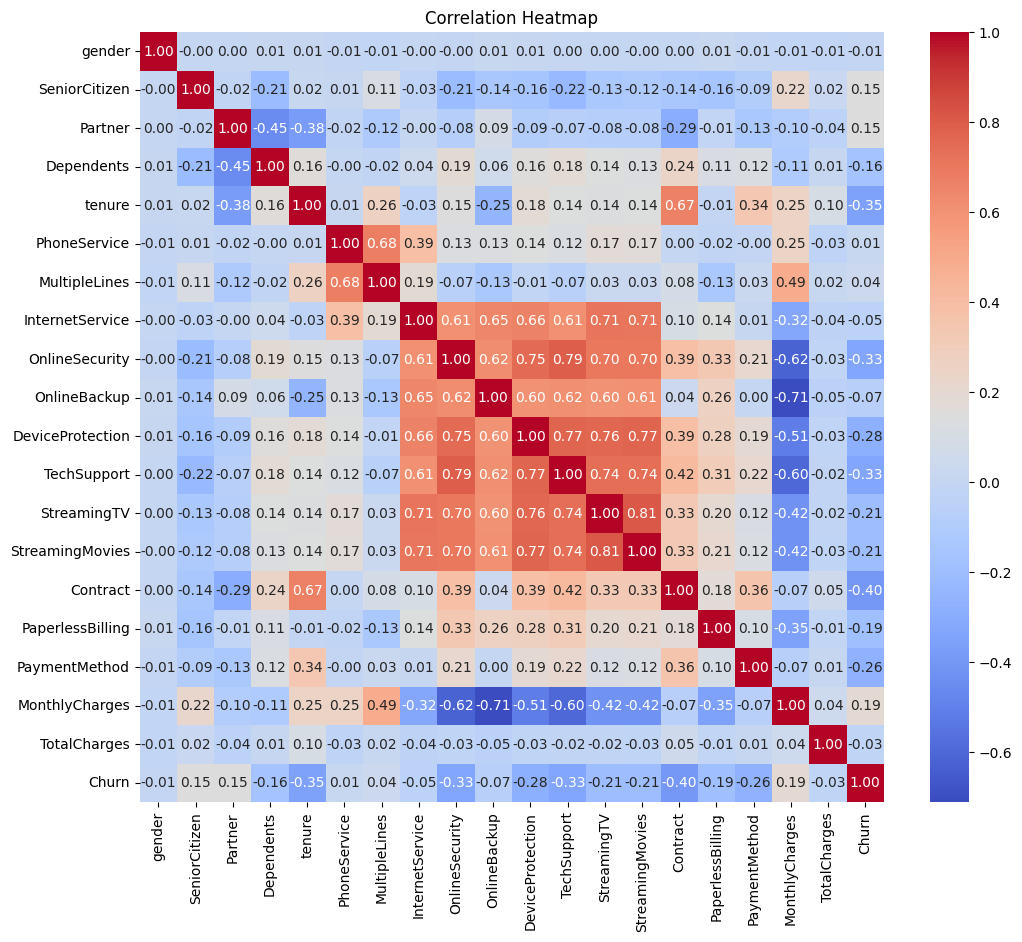

In [43]:
# Encode categorical columns (excluding customerID)
df_encoded = df.copy()
for col in df_encoded.select_dtypes(include='object').columns:
    if col != 'customerID':
        df_encoded[col] = pd.factorize(df_encoded[col])[0]

# Drop customerID before computing correlation
df_encoded = df_encoded.drop(columns=['customerID'])

# Generate and plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df_encoded.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

Positive correlations with churn: PaymentMethod (+0.26), PaperlessBilling (+0.19), and MonthlyCharges (+0.19). THis might indicate that  customers using electronic payments and paying higher bills are more likely to churn.

Negative correlations: Contract (−0.40), tenure (−0.35), OnlineSecurity (−0.33), and TechSupport (−0.33). Longer commitments and bundled services reduce churn risk.

Weak correlations (near 0), like gender, StreamingTV, and StreamingMovies, have little to no predictive relationship with churn.

In [44]:
# Clean and preprocess
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
le = LabelEncoder()

# Encode categorical columns (except customerID)
for col in df.select_dtypes(include='object').columns:
    if col != 'customerID':
        df[col] = le.fit_transform(df[col])

# Define features and target
X = df.drop(['Churn', 'customerID'], axis=1)
y = df['Churn']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


# Predict
y_pred = rf.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.63      0.48      0.54       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.79      0.78      1407



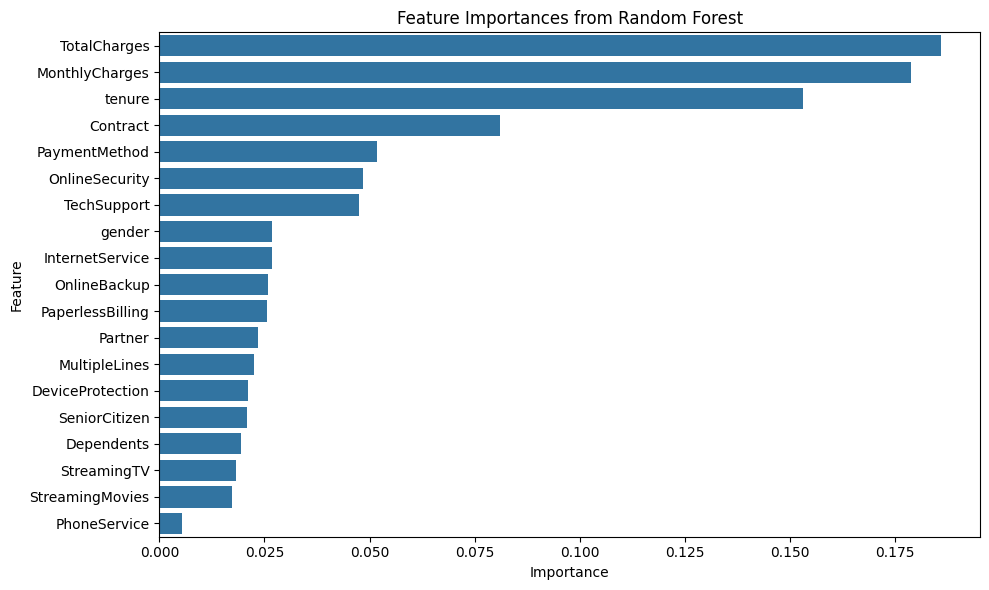

In [45]:
# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title("Feature Importances from Random Forest")
plt.tight_layout()
plt.show()


In [48]:
# Select features with importance > 0.050
selector = SelectFromModel(rf, threshold=0.01, prefit=True)
X_train_reduced = selector.transform(X_train)
X_test_reduced = selector.transform(X_test)

# Retrain model on reduced features
rf_reduced = RandomForestClassifier(n_estimators=100, random_state=42)
rf_reduced.fit(X_train_reduced, y_train)

# Evaluate reduced model
y_pred_reduced = rf_reduced.predict(X_test_reduced)
print("After Dropping Low-Importance Features:\n", classification_report(y_test, y_pred_reduced))


After Dropping Low-Importance Features:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86      1033
           1       0.64      0.47      0.54       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.79      0.78      1407

